# Homework 1

## 1. Data preparation

In [263]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal


In [264]:
df = pd.read_csv("cowid-covid-data.csv")
df_rus = df[(df.location == "Russia") & (df.date >= "2020-03-03")]
columns = ["date", "total_cases", "new_cases"]
df_rus = df_rus[columns]
df_rus.date = pd.to_datetime(df_rus.date)
df_rus.loc[df_rus.new_cases == 0, "new_cases"] += 1
df_rus["day"] = np.arange(df_rus.shape[0])
df_rus

,date,total_cases,new_cases,day
123786,2020-03-03,3.0,1.0,0
123787,2020-03-04,3.0,1.0,1
123788,2020-03-05,4.0,1.0,2
123789,2020-03-06,13.0,9.0,3
123790,2020-03-07,13.0,1.0,4
...,...,...,...,...
124514,2022-03-01,16257688.0,96092.0,728
124515,2022-03-02,16353868.0,96180.0,729
124516,2022-03-03,16445802.0,91934.0,730
124517,2022-03-04,16533932.0,88130.0,731


In [265]:
DAY_SLICE = 50

df_train = df_rus.iloc[:DAY_SLICE]
df_test = df_rus.iloc[DAY_SLICE:]
print(df_train.shape, df_test.shape)

(50, 4) (683, 4)


In [266]:
X_train = np.array(df_train.day)[:, np.newaxis]
X_test = np.array(df_test.day)[:, np.newaxis]
X = np.array(df_rus.day)[:, np.newaxis]

y_total_train = np.array(df_train.total_cases)
y_total_test = np.array(df_test.total_cases)
y_total = np.array(df_rus.total_cases)

y_new_train = np.array(df_train.new_cases)
y_new_test = np.array(df_test.new_cases)


## 2. Linear regression, aposterior distribution, exponents

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.


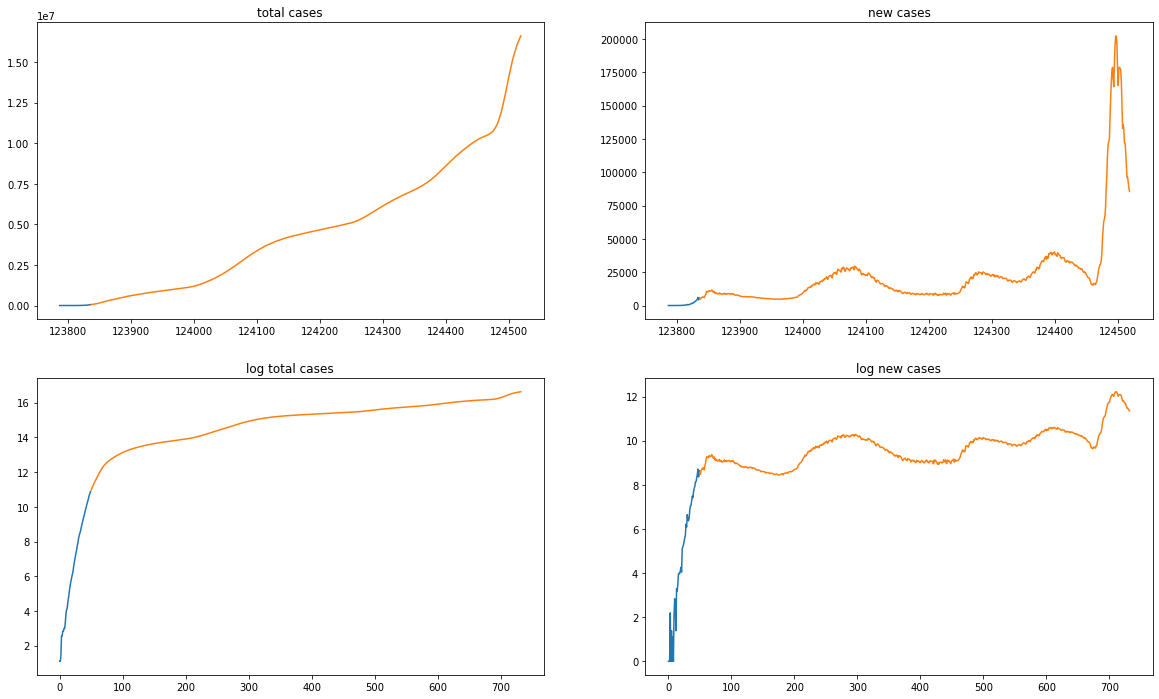

In [267]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

ax[0, 0].plot(df_train.total_cases)
ax[0, 0].plot(df_test.total_cases)
ax[0, 0].set_title("total cases")

ax[0, 1].plot(df_train.new_cases)
ax[0, 1].plot(df_test.new_cases)
ax[0, 1].set_title("new cases")

ax[1, 0].plot(X_train, np.log(y_total_train))
ax[1, 0].plot(X_test, np.log(y_total_test))
ax[1, 0].set_title("log total cases")

ax[1, 1].plot(X_train, np.log(y_new_train))
ax[1, 1].plot(X_test, np.log(y_new_test))
ax[1, 1].set_title("log new cases")

plt.show()

### 2 a. Linear regression

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.


In [268]:
def exp_func(x, a, b):
    return a * np.exp(x * b)

In [269]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, np.log(y_total_train))

y_total_pred = lin_reg.predict(X)
y_total_pred.shape

(733,)

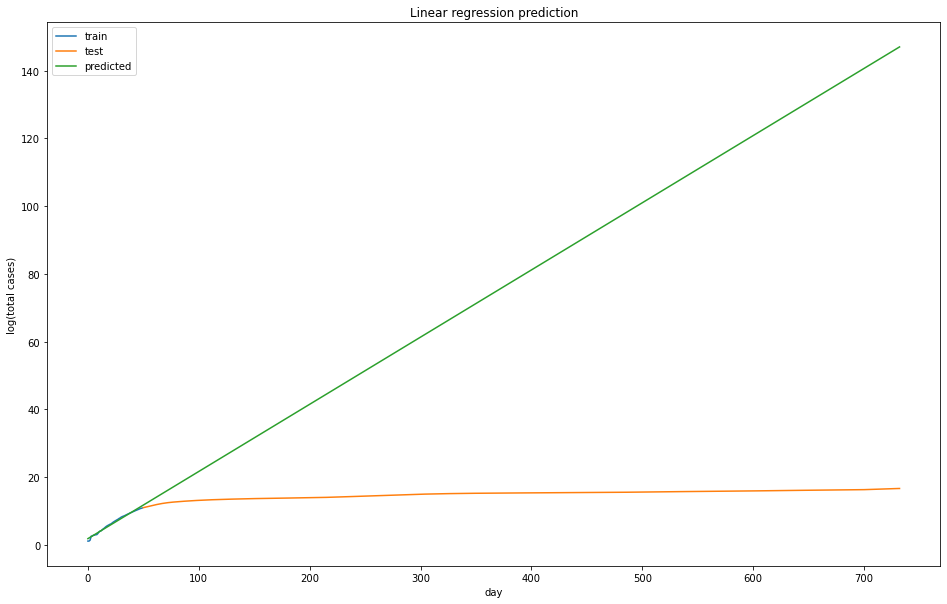

In [270]:
plt.figure(figsize=(16, 10))

plt.plot(X_train, np.log(y_total_train), label="train")
plt.plot(X_test, np.log(y_total_test), label="test")
plt.plot(X, y_total_pred, label="predicted")

plt.title("Linear regression prediction")
plt.legend(loc="upper left")
plt.xlabel("day")
plt.ylabel("log(total cases)")
plt.show()

### 2 b. Aposterior distribution

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).


In [271]:
noise_std = (np.log(y_total_train) - lin_reg.predict(X_train)).var()
mu0 = np.array([0, 0])
sigma0 = 100 * np.eye(2)
X_stack = np.hstack((np.ones((len(X_train), 1)), X_train))

In [272]:
def bayes_params(mu0, sigma0, x, y, noise_std):
    sigma = np.linalg.inv(np.linalg.inv(sigma0) + (1 / noise_std) * np.transpose(x) @ x)
    mu = np.matmul(sigma, np.matmul(np.linalg.inv(sigma0), np.transpose(mu0)) + (1 / noise_std) * np.matmul(np.transpose(x), y))
    return mu, sigma

In [273]:
mu, sigma = bayes_params(mu0, sigma0, X_stack, np.log(y_total_train), noise_std)
print(f"mu = {mu}; sigma = {sigma}")

mu = [1.8205655  0.19829611]; sigma = [[ 9.45888140e-03 -2.86632761e-04]
 [-2.86632761e-04  1.16995814e-05]]


C:\Users\ANDREY~1.KOZ\AppData\Local\Temp/ipykernel_14036/4134464968.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X_plt, Y_plt, Z, cmap=plt.cm.rainbow)


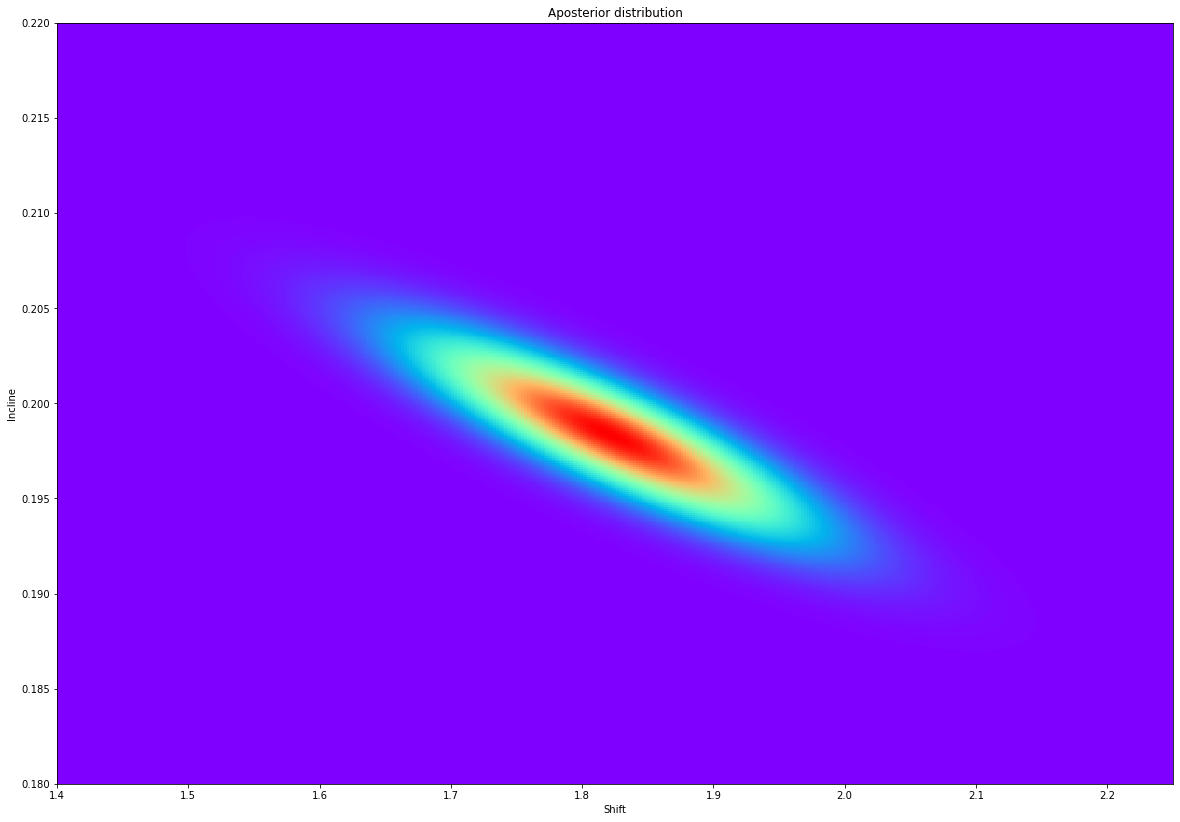

In [274]:
N = 400

X_plt = np.linspace(1.4, 2.25, N)
Y_plt = np.linspace(0.18, 0.22, N)
X_plt, Y_plt = np.meshgrid(X_plt, Y_plt)

pos = np.empty(X_plt.shape + (2,))
pos[:, :, 0] = X_plt
pos[:, :, 1] = Y_plt
Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)
plt.figure(figsize=(20, 14))
plt.pcolormesh(X_plt, Y_plt, Z, cmap=plt.cm.rainbow)
plt.title('Aposterior distribution')
plt.xlabel('Shift')
plt.ylabel('Incline')
plt.show()

###  2 c. Exponents sampling

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).


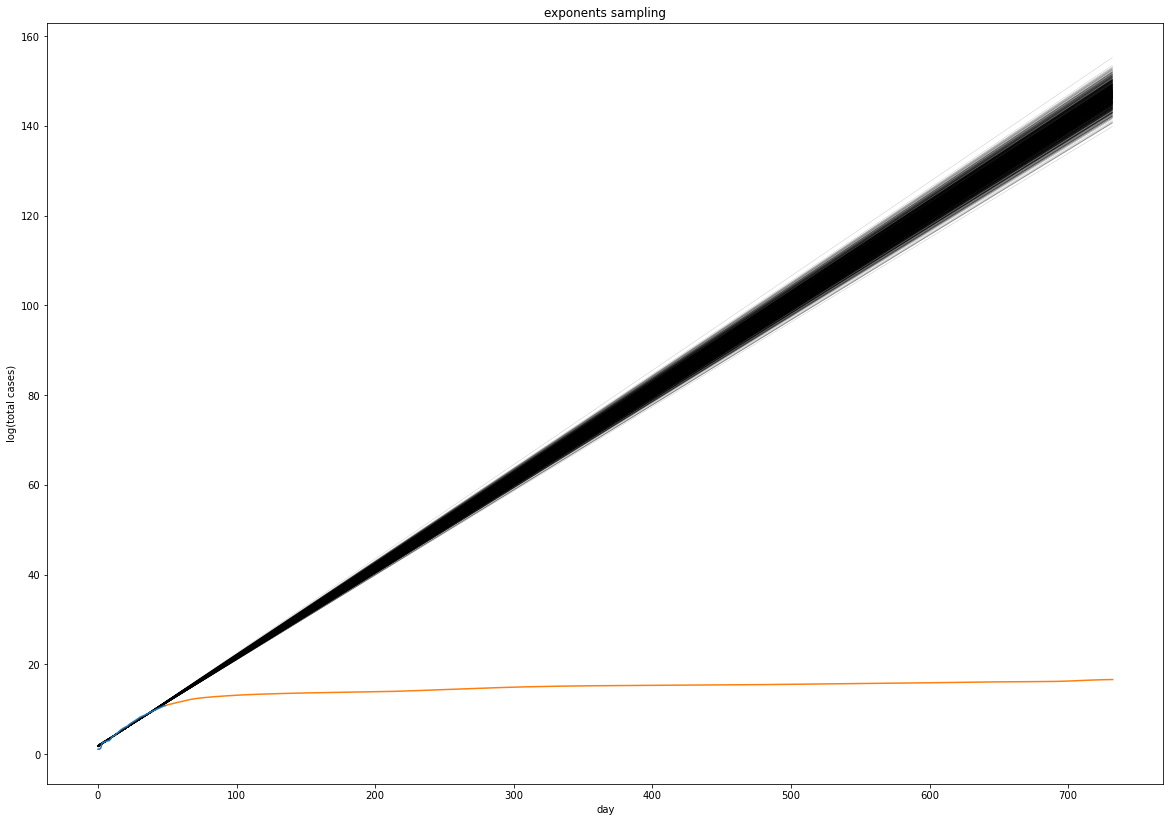

In [275]:
n_samples = 1000
weights = np.random.multivariate_normal(mu, sigma, n_samples)

plt.figure(figsize=(20, 14))

x_s = np.arange(df_rus.shape[0])
for w1, w2 in weights:
    plt.plot(x_s, w1 + w2 *  x_s, "-", color="k", lw=0.1)

plt.plot(X_train, np.log(y_total_train))
plt.plot(X_test, np.log(y_total_test))

plt.title("exponents sampling")
plt.xlabel("day")
plt.ylabel("log(total cases)")
plt.show()

In [276]:
start_date = pd.to_datetime("2020-03-03")
dates_list = ["2020-05-01", "2020-06-01", "2020-09-01"]
dates_list = [pd.to_datetime(el) for el in dates_list]

searched_raws = [df_rus.loc[df_rus.date == el] for el in dates_list]

for i, date in enumerate(dates_list):
    print("======")
    print("date:", date)
    print("true total cases:", *searched_raws[i].total_cases.to_numpy())
    day = date - start_date
    day = day.days + 1
    day = np.array([[day]])
    pred_log = lin_reg.predict(day)
    pred_exp = np.exp(pred_log)
    print("predicted total cases:", *pred_exp)

date: 2020-05-01 00:00:00
true total cases: 114431.0
predicted total cases: 907266.8422205955
date: 2020-06-01 00:00:00
true total cases: 414328.0
predicted total cases: 423985651.3001129
date: 2020-09-01 00:00:00
true total cases: 997072.0
predicted total cases: 3.548811001911415e+16


In [277]:
def predictive_distribution(date, start_date=start_date):
    n_samples = 1000
    days = (date - start_date).days + 1
    weights = np.random.multivariate_normal(mu, sigma, n_samples)
    preds = np.exp(weights[:, 0] + weights[:, 1] * days)
    plt.hist(preds, bins = 30)
    print("date:", date)
    print("mean total number:", int(np.mean(preds)))
    plt.title("predictive distribution")
    plt.xlabel("cases number")
    plt.ylabel("count")
    plt.show()

date: 2020-05-01 00:00:00
mean total number: 916071


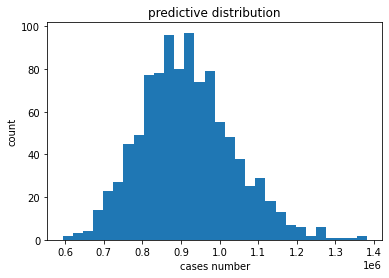

In [278]:
predictive_distribution(dates_list[0])

date: 2020-06-01 00:00:00
mean total number: 432682279


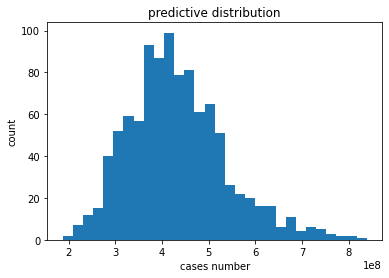

In [279]:
predictive_distribution(dates_list[1])

date: 2020-09-01 00:00:00
mean total number: 40905617175735816


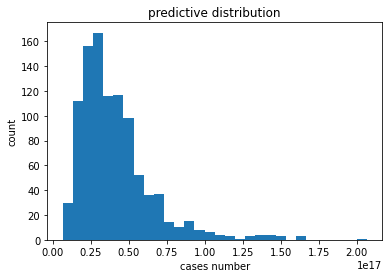

In [280]:
predictive_distribution(dates_list[2])

## 3. Sigmoid fitting

### 3 a.

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.


CDF of sigmoid function is:

$$\Phi(x)=\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x}e^{\frac{-t^2}{2}}dt$$


We can fit PDF of sigmoid function, which can be derived as:

$$pdf(x) = e^{ax^2 + bx +c}$$

we can get log from pdf function, and simply fit the quadratic function:

$$y = ax^2 + bx +c$$

And now we need to use new cases as y variable

## 3 b.

Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.


In [281]:
def create_polynomial_feature(X):
    bias = np.ones(X.shape[0])
    return np.stack([bias, X[:, 0], X[:, 0] ** 2], axis=1)

In [282]:
X_poly = create_polynomial_feature(X)
X_train_poly = create_polynomial_feature(X_train)
X_test_poly = create_polynomial_feature(X_test)


In [283]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, np.log(y_new_train))

y_new_pred = lin_reg.predict(X_poly)
y_new_pred.shape


(733,)

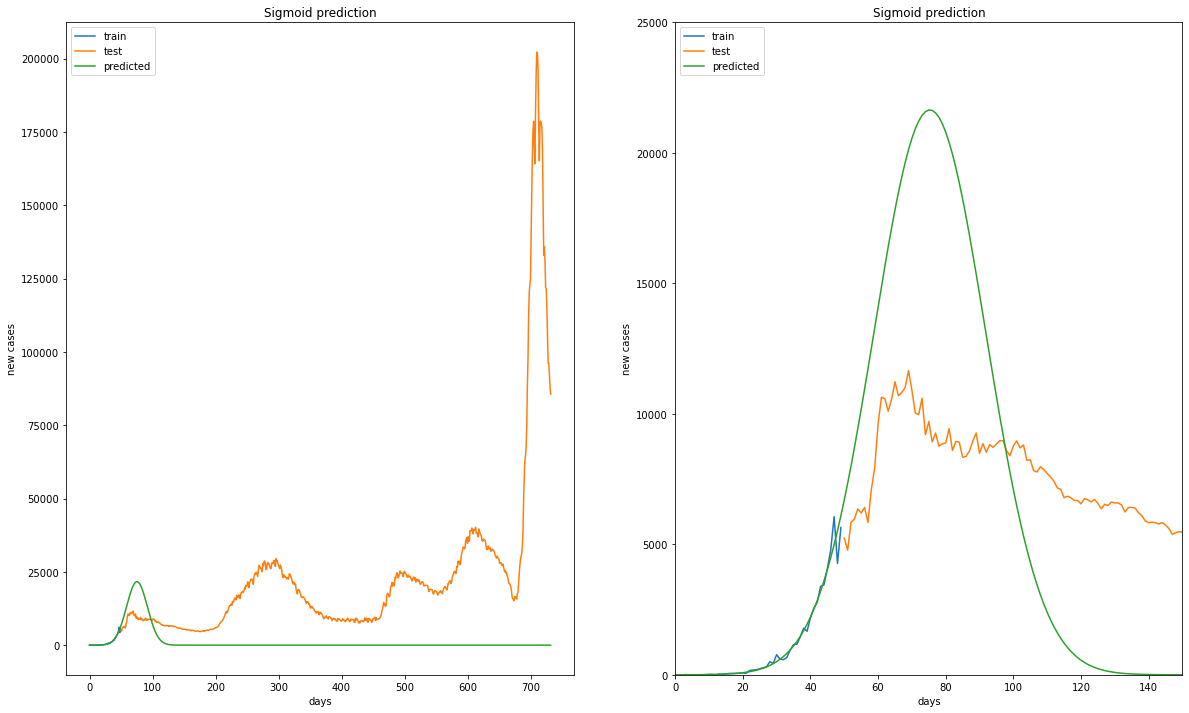

In [284]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].plot(X_train, y_new_train, label="train")
ax[0].plot(X_test, y_new_test, label="test")
ax[0].plot(X, np.exp(y_new_pred), label="predicted")

ax[0].set_title("Sigmoid prediction")
ax[0].legend(loc="upper left")
ax[0].set_xlabel("days")
ax[0].set_ylabel("new cases")

ax[1].plot(X_train, y_new_train, label="train")
ax[1].plot(X_test, y_new_test, label="test")
ax[1].plot(X, np.exp(y_new_pred), label="predicted")

ax[1].set_title("Sigmoid prediction")
ax[1].legend(loc="upper left")
ax[1].set_xlim([0, 150])
ax[1].set_ylim([0, 25000])
ax[1].set_xlabel("days")
ax[1].set_ylabel("new cases")

plt.show()

In [285]:
noise_std = (np.log(y_new_train) - lin_reg.predict(X_train_poly)).var()
mu0 = np.array([0, 0, 0])
sigma0 = 100 * np.eye(3)

mu, sigma = bayes_params(mu0, sigma0, X_train_poly, np.log(y_new_train), noise_std)
print(f"mu = {mu}; sigma = {sigma}")


mu = [-0.39642376  0.27560911 -0.00182956]; sigma = [[ 3.97858000e-02 -3.21446447e-03  5.41155378e-05]
 [-3.21446447e-03  3.54467031e-04 -6.76539758e-06]
 [ 5.41155378e-05 -6.76539758e-06  1.38075588e-07]]


## 3 c.

Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?


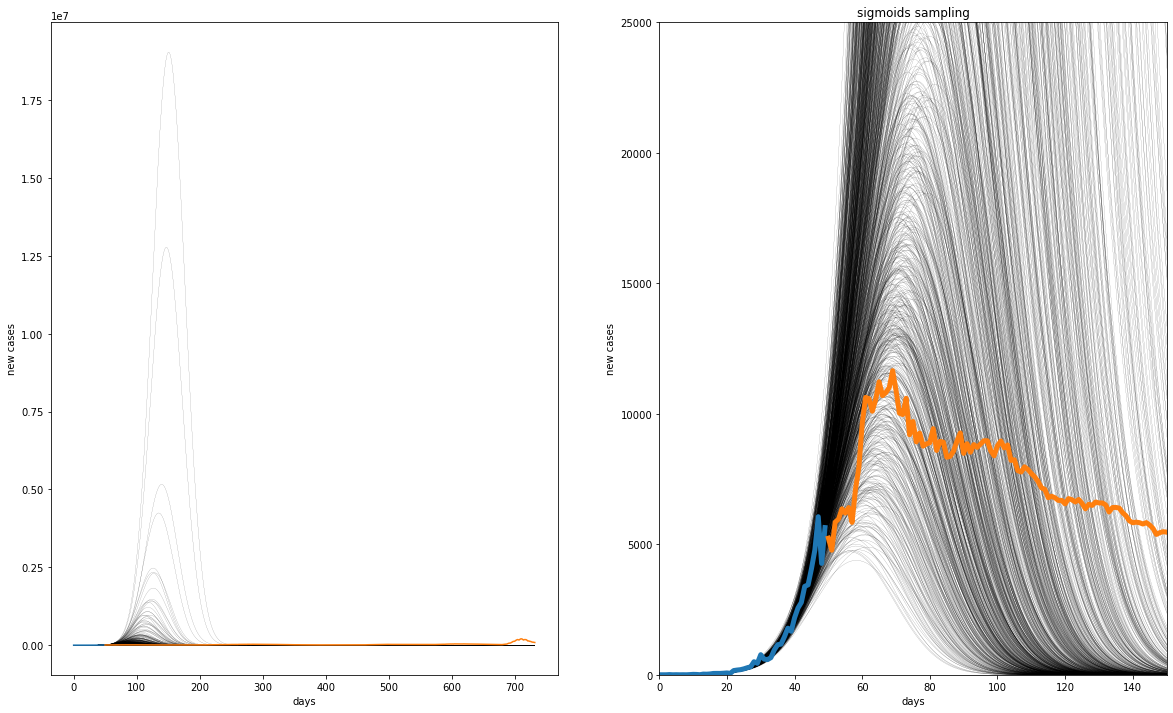

In [286]:
n_samples = 1000
weights = np.random.multivariate_normal(mu, sigma, n_samples)

fig, ax = plt.subplots(1, 2, figsize=(20, 12))

x_s = np.arange(df_rus.shape[0])
y_pred_list = []
for w1, w2, w3 in weights:
    y_pred = w1 + w2 *  x_s + w3 * x_s ** 2
    y_pred = np.exp(y_pred)
    y_pred_list.append(y_pred)
    ax[0].plot(x_s, y_pred, "-", color="k", lw=0.1)
    ax[1].plot(x_s, y_pred, "-", color="k", lw=0.1)

ax[0].plot(X_train, y_new_train)
ax[0].plot(X_test, y_new_test)
ax[1].plot(X_train, y_new_train, lw=5)
ax[1].plot(X_test, y_new_test, lw=5)

ax[1].set_xlim([0, 150])
ax[1].set_ylim([0, 25000])

ax[0].set_xlabel("days")
ax[0].set_ylabel("new cases")
ax[1].set_xlabel("days")
ax[1].set_ylabel("new cases")

plt.title("sigmoids sampling")
plt.show()

In [287]:
y_pred_list = np.array(y_pred_list)
infected_cases = y_pred_list.cumsum(axis=1)

In [288]:
start_date = pd.to_datetime("2020-03-03")
dates_list = ["2020-05-01", "2020-06-01", "2020-09-01"]
dates_list = [pd.to_datetime(el) for el in dates_list]

searched_raws = [df_rus.loc[df_rus.date == el] for el in dates_list]

for i, date in enumerate(dates_list):
    print("======")
    print("date:", date)
    print("true total cases:", *searched_raws[i].total_cases.to_numpy())
    day = date - start_date
    day = day.days + 1
    preds = infected_cases[:, day]
    print("predicted mean total cases:", int(np.mean(preds)))
    print("prediction pessemistic scenario:", int(np.percentile(preds, 90)))
    print("prediction optimistic scenario:", int(np.percentile(preds, 10)))


date: 2020-05-01 00:00:00
true total cases: 114431.0
predicted mean total cases: 173927
prediction pessemistic scenario: 236436
prediction optimistic scenario: 121553
date: 2020-06-01 00:00:00
true total cases: 414328.0
predicted mean total cases: 1234354
prediction pessemistic scenario: 2485887
prediction optimistic scenario: 308496
date: 2020-09-01 00:00:00
true total cases: 997072.0
predicted mean total cases: 6009305
prediction pessemistic scenario: 5793811
prediction optimistic scenario: 321351


In [289]:
def predictive_distribution(date, start_date=start_date):
    day = (date - start_date).days + 1
    preds = infected_cases[:, day]
    plt.hist(preds, bins = 30)
    print("date:", date)
    print("mean total number:", int(np.mean(preds)))
    plt.title("predictive distribution")
    plt.xlabel("cases number")
    plt.ylabel("count")
    plt.show()

date: 2020-05-01 00:00:00
mean total number: 173927


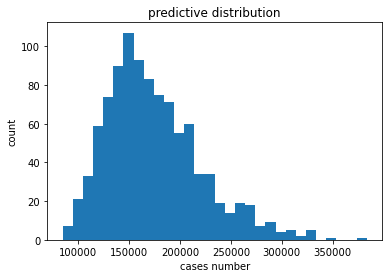

In [290]:
predictive_distribution(dates_list[0])

date: 2020-06-01 00:00:00
mean total number: 1234354


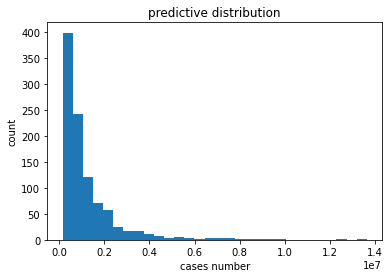

In [291]:
predictive_distribution(dates_list[1])

date: 2020-09-01 00:00:00
mean total number: 6009305


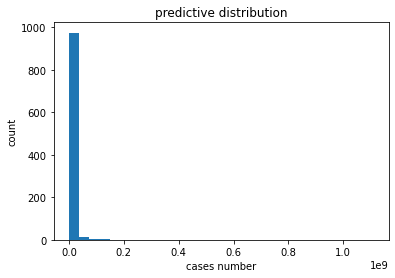

In [292]:
predictive_distribution(dates_list[2])

## 4

Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?


Sorry, i have no time to do this task. My company relocate to the Kazakhstan, due to political world situation. And the last week before deadline was filled with activities for temporary accommodation in KZ.

# 5. Exercise overview

As we can see, day = 80 is boundary, where exponential coefficient changes. I think, for a good prediction, we need to drop first 80 days and works only with second part of data. And we can simply describe this data with exponential distribution, not sigmoidal